In [138]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.corpus import stopwords
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

# Import Data & EDA

In [2]:
course_df = pd.read_excel("uni_courses.xlsx")
course_df

Univ_ID                                        Course Name  \
0           1  Approaches to Knowledge: Introduction to Inter...   
1           1                       Information Through the Ages   
2           1                               Computers and Humans   
3           1                               Migration and Health   
4           1                          Race, Gender and Feminism   
...       ...                                                ...   
1143       76                  INTRODUCTION TO CLIMATE DIPLOMACY   
1144       76              GOVERNING BORDERS IN THE 21ST CENTURY   
1145       76                AGRICULTURE, FOOD AND GLOBALIZATION   
1146       76                             BEHAVIORAL GAME THEORY   
1147       76                               COMPARATIVE POLITICS   

                                                Details  
0      This module provides an introduction to inter...  
1      This module explores the concept of informati...  
2      Should we trust news in a Deepfake world? Sho...  
3      In this course, you will analyse the interpla...  
4      This module offers an introduction and analyt...  
...                                                 ...  
1143   This class is aimed at students willing to un...  
1144   This course offers an introduction to the stu...  
1145   With the war in Ukraine, the Covid crisis, so...  
1146   Game theory is a formal language to describe ...  
1147   What is Comparative Politics? How do we analy...  

[1148 rows x 3 columns]

## WordCloud Course Name

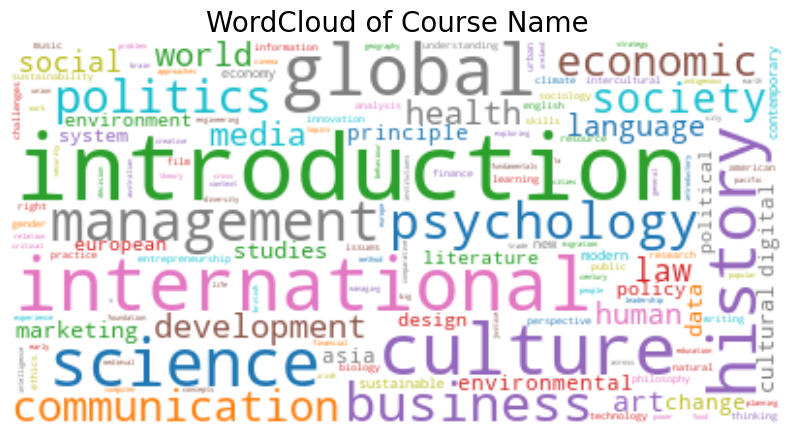

In [13]:
course_name = course_df["Course Name"].to_list()
course_name = [i.lower() for i in course_name]

stopwords_list = list(set(stopwords.words('english')))

for i in range(len(course_name)):
    tokens = word_tokenize(course_name[i])
    filtered_tokens = [t for t in tokens if t not in stopwords_list]
    filtered_text = ' '.join(filtered_tokens)
    course_name[i] = filtered_text

course_name_wc = " ".join(course_name)
word_cloud = WordCloud(collocations = False, background_color = 'white', colormap="tab10").generate(course_name_wc)
plt.figure(figsize=(10,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("WordCloud of Course Name", fontsize=20)
plt.axis("off")
plt.show()

## Histogram Panjang Course Description

In [173]:
course_desc = course_df["Details"].fillna("").to_list()
course_desc = [i.lower() for i in course_desc]

stopwords_list = list(set(stopwords.words('english')))
for i in range(len(course_desc)):
    tokens = word_tokenize(course_desc[i])
    filtered_tokens = [t for t in tokens if t not in stopwords_list]
    filtered_text = ' '.join(filtered_tokens)
    course_desc[i] = filtered_text

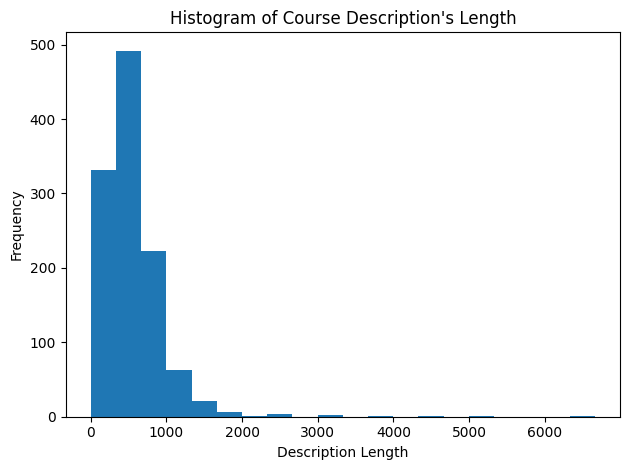

In [181]:
len_course_desc = [len(i) for i in course_desc]

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = "center")

plt.hist(len_course_desc, bins=20)
plt.title("Histogram of Course Description's Length")
plt.xlabel("Description Length")
plt.ylabel("Frequency")
plt.tight_layout()

## Preprocessing

In [14]:
def prep_course(df: pd.DataFrame, column: str) -> list:
    list_column = df[column].fillna("").to_list()
    list_column = [i.lower().strip() for i in list_column]
    list_column = [i.lower().strip() for i in list_column]
    list_column = [i.replace("amp;", "") for i in list_column]
    return list_column

course_name = prep_course(course_df, "Course Name")
course_details = prep_course(course_df, "Details")

prep_data = []
for i in range(len(course_name)):
    if course_details != "":
        prep_data.append(f"{course_name[i]}. {course_details[i]}")
    else:
        prep_data.append(course_name[i])

print(prep_data)

['approaches to knowledge: introduction to interdisciplinarity. this module provides an introduction to interdisciplinarity in particular, its role in breaking down traditional boundaries and creating new kinds of knowledge. we address the issues facing those conducting interdisciplinary work and examine how they play out in practice. we look at the reality of working in new fields and, perhaps most importantly, in new ways.', 'information through the ages. this module explores the concept of information and its relation to data and knowledge, taking an historical perspective through examining the past, present and future of associated institutional repositories and collections (libraries, archives, museums, galleries, data vaults) as well as the different historical forms of information sources (moving from the papyrus and codex up to contemporary forms such as the database). the module engages students in a critical, interdisciplinary examination of the role institutions and collecti

In [23]:
import pickle
with open('prep_datalist.pkl', 'wb') as f:
    pickle.dump(prep_data, f)

# KeyBERT (Baseline)

In [15]:
embedding = 'all-mpnet-base-v2'
key_model = KeyBERT(model=embedding)

In [16]:
keybert_keywords = []
for idx in tqdm(range(0, len(prep_data))):
    keywords = key_model.extract_keywords(prep_data[idx], keyphrase_ngram_range=(1,3), stop_words='english', top_n=7)
    keywords_list = list(dict(keywords).keys())
    keybert_keywords.append(keywords_list)

100%|██████████| 1148/1148 [02:21<00:00,  8.13it/s]


In [17]:
keybert_keywords[0:3]

[['knowledge introduction interdisciplinarity',
  'introduction interdisciplinarity',
  'interdisciplinarity',
  'introduction interdisciplinarity particular',
  'provides introduction interdisciplinarity',
  'interdisciplinarity particular',
  'introduction interdisciplinarity module'],
 ['knowledge taking historical',
  'information',
  'information ages',
  'information information sources',
  'libraries archives museums',
  'information information',
  'information sources scrutinises'],
 ['computers humans',
  'concepts human computer',
  'computing systems human',
  'human computer',
  'computers humans trust',
  'ai',
  'computer interaction']]

# KeyBERT with Rule-Based N-Gram

In [18]:
keybertrule_keywords = []
for idx in tqdm(range(0, len(prep_data))):
    curr_keywords = []
    curr_rlv = []
    keywords_trigram = key_model.extract_keywords(prep_data[idx], keyphrase_ngram_range=(3,3), stop_words='english', top_n=2)
    keywords_trigram_list = list(dict(keywords_trigram).keys())

    rlv_count = 0
    for rlv in list(dict(keywords_trigram).values()):
        if rlv >= 0.75:
            curr_keywords.append(keywords_trigram_list[rlv_count])
            curr_rlv.append(rlv)
        rlv_count += 1

    keywords_bigram = key_model.extract_keywords(prep_data[idx], keyphrase_ngram_range=(2,2), stop_words='english', top_n=4)
    keywords_bigram_list = list(dict(keywords_bigram).keys())

    rlv_count = 0
    for rlv in list(dict(keywords_bigram).values()):
        if rlv >= 0.75:
            curr_keywords.append(keywords_bigram_list[rlv_count])
            curr_rlv.append(rlv)
        rlv_count += 1
    
    if len(curr_keywords) != 7: 
        keywords_unigram = key_model.extract_keywords(prep_data[idx], keyphrase_ngram_range=(1,1), stop_words='english', top_n=7-len(curr_keywords))
    curr_keywords += list(dict(keywords_unigram).keys())
    curr_rlv += list(dict(keywords_unigram).values())

    sorted_tuples = sorted(zip(curr_keywords, curr_rlv), key=lambda x: x[1], reverse=True)
    sorted_keywords = [t[0] for t in sorted_tuples]
    keybertrule_keywords.append(sorted_keywords)

100%|██████████| 1148/1148 [04:00<00:00,  4.78it/s]


In [19]:
keybertrule_keywords[0:3]

[['knowledge introduction interdisciplinarity',
  'introduction interdisciplinarity',
  'interdisciplinarity',
  'introduction interdisciplinarity particular',
  'interdisciplinarity particular',
  'interdisciplinary work',
  'interdisciplinary'],
 ['information',
  'libraries',
  'museums',
  'knowledge',
  'archives',
  'historical',
  'database'],
 ['ai',
  'computing',
  'computers',
  'wearable',
  'visualisation',
  'design',
  'autonomous']]

# Enhanced KeyBERT

In [20]:
vectorizer_params = KeyphraseCountVectorizer(spacy_pipeline='en_core_web_sm', pos_pattern='<J.*>*<N.*>+', stop_words='english', lowercase=True)

In [21]:
enhancedkeybert_keywords = []
for idx in tqdm(range(0, len(prep_data))):
    keywords = key_model.extract_keywords(prep_data[idx], vectorizer=vectorizer_params, stop_words='english', top_n=7, use_mmr=True)
    keywords_list = list(dict(keywords).keys())
    enhancedkeybert_keywords.append(keywords_list)

100%|██████████| 1148/1148 [11:18<00:00,  1.69it/s]


In [22]:
enhancedkeybert_keywords[0:3]

[['interdisciplinarity',
  'interdisciplinary work',
  'knowledge',
  'introduction',
  'traditional boundaries',
  'new fields',
  'module'],
 ['information',
  'museums',
  'different historical forms',
  'associated institutional repositories',
  'data vaults',
  'cultural elements',
  'papyrus'],
 ['ai',
  'human computer interaction',
  'wearable technologies',
  'design issues',
  'humans',
  'risks',
  'lectures']]

# Evaluation

## Sampling

Cluster sampling berdasarkan ID University

In [29]:
course_qty = len(course_df)
uni_qty = course_df["Univ_ID"].to_list()[-1]
course_to_uni_ratio = course_qty//uni_qty
print(course_to_uni_ratio, "course per university")

15 course per university


In [51]:
pre_sample_df = pd.concat([course_df["Univ_ID"], pd.Series(prep_data)], axis=1)
pre_sample_df.rename(columns={0: "Details"}, inplace=True)
pre_sample_df

Univ_ID                                            Details
0           1  approaches to knowledge: introduction to inter...
1           1  information through the ages. this module expl...
2           1  computers and humans. should we trust news in ...
3           1  migration and health. in this course, you will...
4           1  race, gender and feminism. this module offers ...
...       ...                                                ...
1143       76  introduction to climate diplomacy. this class ...
1144       76  governing borders in the 21st century. this co...
1145       76  agriculture, food and globalization. with the ...
1146       76  behavioral game theory. game theory is a forma...
1147       76  comparative politics. what is comparative poli...

[1148 rows x 2 columns]

In [53]:
np.random.seed(42)
def select_random_courses(group):
    return group.sample(n=min(5, group.shape[0]))

sample_df = pre_sample_df.groupby('Univ_ID', group_keys=False).apply(select_random_courses).reset_index(drop=True)
sample_df

Univ_ID                                            Details
0          1  approaches to knowledge: introduction to inter...
1          1  creative writing. weekly lecture and workshop-...
2          1  quantitative methods 2: data science and visua...
3          1  information through the ages. this module expl...
4          1  introduction into politics: key concepts and t...
..       ...                                                ...
375       76  governing borders in the 21st century. this co...
376       76  women in movement: history of feminisms from t...
377       76  comparative politics. what is comparative poli...
378       76  trade and international finance. the objective...
379       76  introduction to climate diplomacy. this class ...

[380 rows x 2 columns]

Setelah ini, akan dilakukan keywords extraction secara manual pada data sampel.

In [56]:
sample_df.to_csv("sample_data.csv", index=False)

## Data Integration

In [90]:
actual_df = pd.read_csv("sample_data.csv")
actual_df

Univ_ID                                            Details  \
0          1  approaches to knowledge: introduction to inter...   
1          1  creative writing. weekly lecture and workshop-...   
2          1  quantitative methods 2: data science and visua...   
3          1  information through the ages. this module expl...   
4          1  introduction into politics: key concepts and t...   
..       ...                                                ...   
375       76  governing borders in the 21st century. this co...   
376       76  women in movement: history of feminisms from t...   
377       76  comparative politics. what is comparative poli...   
378       76  trade and international finance. the objective...   
379       76  introduction to climate diplomacy. this class ...   

                                                 Label    ID  
0    interdisciplinarity, knowledge, traditional bo...     0  
1    creative writing, prose fiction, poetry, creat...    17  
2    quantitative methods, data science, visualisat...    15  
3    information, data, knowledge, historical persp...     1  
4    politics, key concepts, texts, political commu...     8  
..                                                 ...   ...  
375  governance, migration, borders, security, 21st...  1144  
376  women, movement, feminisms, history, activism,...  1142  
377  comparative politics, analysis, political inst...  1147  
378  international finance, international trade, gl...  1138  
379  climate diplomacy, international politics, fig...  1143  

[380 rows x 4 columns]

In [91]:
course_df

Univ_ID                                        Course Name  \
0           1  Approaches to Knowledge: Introduction to Inter...   
1           1                       Information Through the Ages   
2           1                               Computers and Humans   
3           1                               Migration and Health   
4           1                          Race, Gender and Feminism   
...       ...                                                ...   
1143       76                  INTRODUCTION TO CLIMATE DIPLOMACY   
1144       76              GOVERNING BORDERS IN THE 21ST CENTURY   
1145       76                AGRICULTURE, FOOD AND GLOBALIZATION   
1146       76                             BEHAVIORAL GAME THEORY   
1147       76                               COMPARATIVE POLITICS   

                                                Details  
0      This module provides an introduction to inter...  
1      This module explores the concept of informati...  
2      Should we trust news in a Deepfake world? Sho...  
3      In this course, you will analyse the interpla...  
4      This module offers an introduction and analyt...  
...                                                 ...  
1143   This class is aimed at students willing to un...  
1144   This course offers an introduction to the stu...  
1145   With the war in Ukraine, the Covid crisis, so...  
1146   Game theory is a formal language to describe ...  
1147   What is Comparative Politics? How do we analy...  

[1148 rows x 3 columns]

In [93]:
result_coll = [keybert_keywords, keybertrule_keywords, enhancedkeybert_keywords]
with open('result_keywords.pkl', 'wb') as f:
    pickle.dump(result_coll, f)

In [97]:
for approach in range(len(result_coll)):
    for text in range(len(result_coll[approach])):
        result_coll[approach][text] = ", ".join(result_coll[approach][text])

result_coll

[['knowledge introduction interdisciplinarity, introduction interdisciplinarity, interdisciplinarity, introduction interdisciplinarity particular, provides introduction interdisciplinarity, interdisciplinarity particular, introduction interdisciplinarity module',
  'knowledge taking historical, information, information ages, information information sources, libraries archives museums, information information, information sources scrutinises',
  'computers humans, concepts human computer, computing systems human, human computer, computers humans trust, ai, computer interaction',
  'migration health course, migration health, migration health physical, inequalities experienced migrants, mental social migrants, migrants significant impact, social migrants',
  'race gender feminism, concepts gender race, gender race critical, intersectionality race gender, approach race gender, gender race, intersectionality race',
  'art interdisciplinarity, approaches art research, art research, art inter

In [108]:
result_df = pd.concat([course_df, pd.Series(prep_data), pd.Series(result_coll[0]), pd.Series(result_coll[1]), pd.Series(result_coll[2])], axis=1)
result_df.reset_index(inplace=True)
result_df.rename({'index':"ID", 0: "Processed", 1: "KeyBERT Base", 2: "KeyBERT + Rule", 3:"KeyBERT + Vectorizer"}, axis=1, inplace=True)
result_df

ID  Univ_ID                                        Course Name  \
0        0        1  Approaches to Knowledge: Introduction to Inter...   
1        1        1                       Information Through the Ages   
2        2        1                               Computers and Humans   
3        3        1                               Migration and Health   
4        4        1                          Race, Gender and Feminism   
...    ...      ...                                                ...   
1143  1143       76                  INTRODUCTION TO CLIMATE DIPLOMACY   
1144  1144       76              GOVERNING BORDERS IN THE 21ST CENTURY   
1145  1145       76                AGRICULTURE, FOOD AND GLOBALIZATION   
1146  1146       76                             BEHAVIORAL GAME THEORY   
1147  1147       76                               COMPARATIVE POLITICS   

                                                Details  \
0      This module provides an introduction to inter...   
1      This module explores the concept of informati...   
2      Should we trust news in a Deepfake world? Sho...   
3      In this course, you will analyse the interpla...   
4      This module offers an introduction and analyt...   
...                                                 ...   
1143   This class is aimed at students willing to un...   
1144   This course offers an introduction to the stu...   
1145   With the war in Ukraine, the Covid crisis, so...   
1146   Game theory is a formal language to describe ...   
1147   What is Comparative Politics? How do we analy...   

                                              Processed  \
0     approaches to knowledge: introduction to inter...   
1     information through the ages. this module expl...   
2     computers and humans. should we trust news in ...   
3     migration and health. in this course, you will...   
4     race, gender and feminism. this module offers ...   
...                                                 ...   
1143  introduction to climate diplomacy. this class ...   
1144  governing borders in the 21st century. this co...   
1145  agriculture, food and globalization. with the ...   
1146  behavioral game theory. game theory is a forma...   
1147  comparative politics. what is comparative poli...   

                                           KeyBERT Base  \
0     knowledge introduction interdisciplinarity, in...   
1     knowledge taking historical, information, info...   
2     computers humans, concepts human computer, com...   
3     migration health course, migration health, mig...   
4     race gender feminism, concepts gender race, ge...   
...                                                 ...   
1143  introduction climate diplomacy, climate diplom...   
1144  governance migration borders, migration border...   
1145  agriculture food globalization, challenges int...   
1146  behavioral game theory, behavioral game, game ...   
1147  comparative politics analyse, study comparativ...   

                                         KeyBERT + Rule  \
0     knowledge introduction interdisciplinarity, in...   
1     information, libraries, museums, knowledge, ar...   
2     ai, computing, computers, wearable, visualisat...   
3     migration health course, migration health, mig...   
4     race gender feminism, intersectionality, femin...   
...                                                 ...   
1143  introduction climate diplomacy, climate diplom...   
1144  governance migration borders, borders, mobilit...   
1145  agriculture food globalization, agriculture, a...   
1146  behavioral game theory, economics, economic, b...   
1147  comparative politics analyse, study comparativ...   

                                   KeyBERT + Vectorizer  
0     interdisciplinarity, interdisciplinary work, k...  
1     information, museums, different historical for...  
2     ai, human computer interaction, wearable techn...  
3     health, migrant, migration, host society, suc

In [109]:
result_df.to_csv("result_data.csv", index=False)

In [116]:
final_eval_df = pd.merge(result_df, actual_df, on=["ID"])
final_eval_df = final_eval_df[["KeyBERT Base", "KeyBERT + Rule", "KeyBERT + Vectorizer", "Label"]]
final_eval_df

KeyBERT Base  \
0    knowledge introduction interdisciplinarity, in...   
1    knowledge taking historical, information, info...   
2    politics key concepts, modules introduction po...   
3    quantitative methods data, data science visual...   
4    student creative writing, creative writing wor...   
..                                                 ...   
375  globalization international trade, trade inter...   
376  movement history feminisms, history feminisms,...   
377  introduction climate diplomacy, climate diplom...   
378  governance migration borders, migration border...   
379  comparative politics analyse, study comparativ...   

                                        KeyBERT + Rule  \
0    knowledge introduction interdisciplinarity, in...   
1    information, libraries, museums, knowledge, ar...   
2    politics, political, machiavelli, aristotle, r...   
3    quantitative, data, visualisation, modelling, ...   
4    student creative writing, writing, prose, poet...   
..                                                 ...   
375  globalization, macroeconomics, macroeconomic, ...   
376  movement history feminisms, history feminisms,...   
377  introduction climate diplomacy, climate diplom...   
378  governance migration borders, borders, mobilit...   
379  comparative politics analyse, study comparativ...   

                                  KeyBERT + Vectorizer  \
0    interdisciplinarity, interdisciplinary work, k...   
1    information, museums, different historical for...   
2    political thinkers, foucault, core texts, intr...   
3    quantitative methods course, data science, vis...   
4    creative writing work, contemporary prose fict...   
..                                                 ...   
375  international trade, many international financ...   
376  world feminisms, international socialist movem...   
377  climate diplomacy, future climate diplomacy, m...   
378  borders, mobilities, governance, migration con...   
379  comparative politics, political systems, insti...   

                                                 Label  
0    interdisciplinarity, knowledge, traditional bo...  
1    information, data, knowledge, historical persp...  
2    politics, key concepts, texts, political commu...  
3    quantitative methods, data science, visualisat...  
4    creative writing, prose fiction, poetry, creat...  
..                                                 ...  
375  international finance, international trade, gl...  
376  women, movement, feminisms, history, activism,...  
377  climate diplomacy, international politics, fig...  
378  governance, migration, borders, security, 21st...  
379  comparative politics, analysis, political inst...  

[380 rows x 4 columns]

In [120]:
def split_comma(keywords):
    return keywords.split(", ")

for col in final_eval_df.columns:
    final_eval_df[col] = final_eval_df[col].apply(split_comma)

final_eval_df

KeyBERT Base  \
0    [knowledge introduction interdisciplinarity, i...   
1    [knowledge taking historical, information, inf...   
2    [politics key concepts, modules introduction p...   
3    [quantitative methods data, data science visua...   
4    [student creative writing, creative writing wo...   
..                                                 ...   
375  [globalization international trade, trade inte...   
376  [movement history feminisms, history feminisms...   
377  [introduction climate diplomacy, climate diplo...   
378  [governance migration borders, migration borde...   
379  [comparative politics analyse, study comparati...   

                                        KeyBERT + Rule  \
0    [knowledge introduction interdisciplinarity, i...   
1    [information, libraries, museums, knowledge, a...   
2    [politics, political, machiavelli, aristotle, ...   
3    [quantitative, data, visualisation, modelling,...   
4    [student creative writing, writing, prose, poe...   
..                                                 ...   
375  [globalization, macroeconomics, macroeconomic,...   
376  [movement history feminisms, history feminisms...   
377  [introduction climate diplomacy, climate diplo...   
378  [governance migration borders, borders, mobili...   
379  [comparative politics analyse, study comparati...   

                                  KeyBERT + Vectorizer  \
0    [interdisciplinarity, interdisciplinary work, ...   
1    [information, museums, different historical fo...   
2    [political thinkers, foucault, core texts, int...   
3    [quantitative methods course, data science, vi...   
4    [creative writing work, contemporary prose fic...   
..                                                 ...   
375  [international trade, many international finan...   
376  [world feminisms, international socialist move...   
377  [climate diplomacy, future climate diplomacy, ...   
378  [borders, mobilities, governance, migration co...   
379  [comparative politics, political systems, inst...   

                                                 Label  
0    [interdisciplinarity, knowledge, traditional b...  
1    [information, data, knowledge, historical pers...  
2    [politics, key concepts, texts, political comm...  
3    [quantitative methods, data science, visualisa...  
4    [creative writing, prose fiction, poetry, crea...  
..                                                 ...  
375  [international finance, international trade, g...  
376  [women, movement, feminisms, history, activism...  
377  [climate diplomacy, international politics, fi...  
378  [governance, migration, borders, security, 21s...  
379  [comparative politics, analysis, political ins...  

[380 rows x 4 columns]

## Precision@7

In [158]:
def precision(pred_col, label_col):
    all_rlv = 0
    for data in range(len(pred_col)):
        pred, label = pred_col[data], label_col[data]
        sum_rlv = 0
        for kw in pred:
            if kw in label:
                sum_rlv += 1
        all_rlv += sum_rlv/len(pred)
    
    return all_rlv / len(pred_col)

prec_base = precision(final_eval_df["KeyBERT Base"], final_eval_df["Label"])
prec_rule = precision(final_eval_df["KeyBERT + Rule"], final_eval_df["Label"])
prec_vector = precision(final_eval_df["KeyBERT + Vectorizer"], final_eval_df["Label"])

print(prec_base, prec_rule, prec_vector)

0.12631578947368455 0.2830827067669178 0.4340100250626561


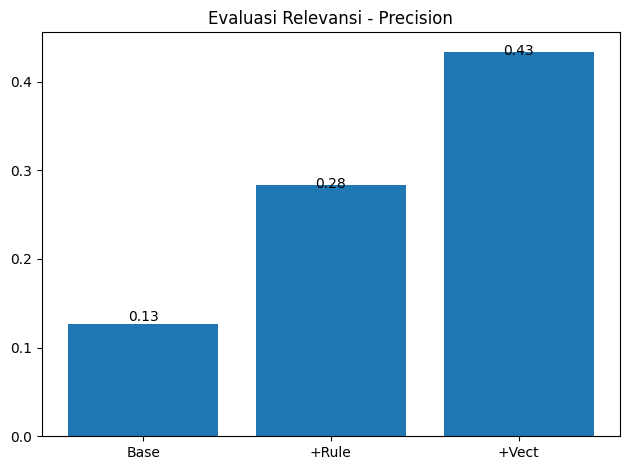

In [159]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = "center")

plt.bar(["Base", "+Rule", "+Vect"], [prec_base, prec_rule, prec_vector])
plt.title("Evaluasi Relevansi - Precision@7")
addlabels(["Base", "+Rule", "+Vect"], [round(prec_base, 2), round(prec_rule, 2), round(prec_vector, 2)])
plt.tight_layout()
plt.show()

## MRR

In [156]:
def mrr_metric(pred_col, label_col):
    sum_rank = 0
    for data in range(len(pred_col)):
        pred, label = pred_col[data], label_col[data]
        for kw in pred:
            if kw in label:
                sum_rank += 1/(label.index(kw)+1)
                break

    return (1/len(pred_col)) * sum_rank

mrr_base = mrr_metric(final_eval_df["KeyBERT Base"], final_eval_df["Label"])
mrr_rule = mrr_metric(final_eval_df["KeyBERT + Rule"], final_eval_df["Label"])
mrr_vector = mrr_metric(final_eval_df["KeyBERT + Vectorizer"], final_eval_df["Label"])

print(mrr_base, mrr_rule, mrr_vector)

0.5378246312375367 0.5604568056212794 0.6069974135551159


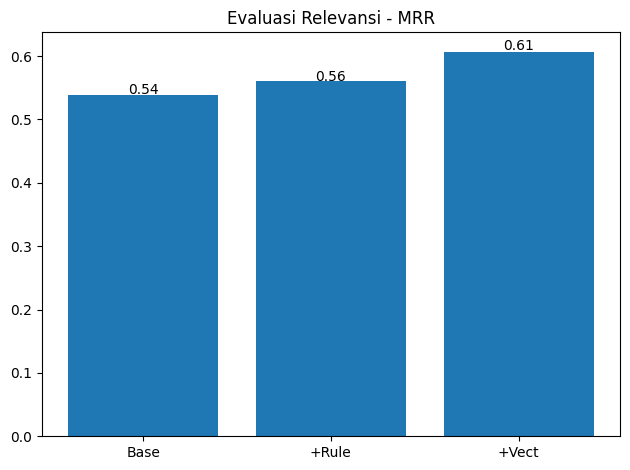

In [157]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = "center")

plt.bar(["Base", "+Rule", "+Vect"], [mrr_base, mrr_rule, mrr_vector])
plt.title("Evaluasi Relevansi - MRR")
addlabels(["Base", "+Rule", "+Vect"], [round(mrr_base, 2), round(mrr_rule, 2), round(mrr_vector, 2)])
plt.tight_layout()
plt.show()

## MAP

In [161]:
def map_metric(pred_col, label_col):
    sum_map = 0
    for data in range(len(pred_col)):
        pred, label = pred_col[data], label_col[data]
        amount_rlv = 0
        counter = 0
        sum_ap = 0
        for kw in pred:
            counter += 1
            if kw in label:
                amount_rlv += 1
                sum_ap += (amount_rlv/counter)

        if amount_rlv == 0:
            sum_map += 0    
        else:
            sum_map += sum_ap/amount_rlv
    
    return sum_map / len(pred_col)

map_base = map_metric(final_eval_df["KeyBERT Base"], final_eval_df["Label"])
map_rule = map_metric(final_eval_df["KeyBERT + Rule"], final_eval_df["Label"])
map_vector = map_metric(final_eval_df["KeyBERT + Vectorizer"], final_eval_df["Label"])

print(map_base, map_rule, map_vector)

0.2785902255639097 0.44860129490392625 0.7185434419381778


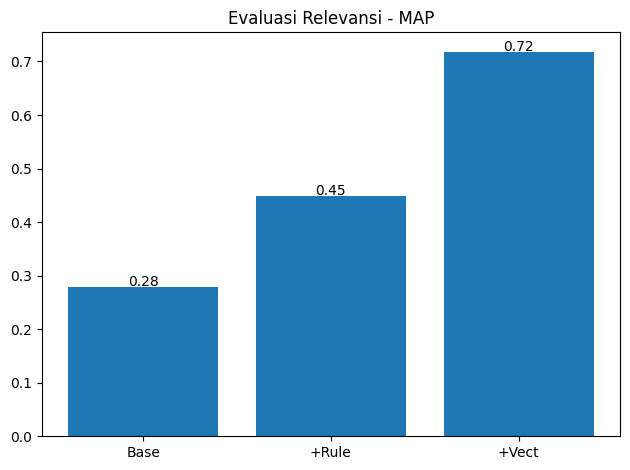

In [162]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = "center")

plt.bar(["Base", "+Rule", "+Vect"], [map_base, map_rule, map_vector])
plt.title("Evaluasi Relevansi - MAP")
addlabels(["Base", "+Rule", "+Vect"], [round(map_base, 2), round(map_rule, 2), round(map_vector, 2)])
plt.tight_layout()
plt.show()

# Deployment

In [163]:
import gradio as gr

In [167]:
def get_keywords(course_name, course_desc):
    keywords_list = []
    course_name, course_desc = course_name.strip().lower(), course_desc.strip().lower()
    data = course_name+". "+course_desc
    keywords = key_model.extract_keywords(data, vectorizer=vectorizer_params, stop_words='english', top_n=7, use_mmr=True)
    keywords_list = list(dict(keywords).keys())
    return ", ".join(keywords_list)
    
iface = gr.Interface(fn=get_keywords, inputs=[gr.Textbox(label="Course Name"), gr.Textbox(label="Course Description")], outputs=gr.Textbox(label="Relevant Tags"),
                     title="Tags Generator", description="Generating tags/keywords based on Keyphrase-BERT Extraction'")
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://cde8b9a25ca3f42df8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Submission

In [170]:
# @title #### Student Identity
student_id = "REAFMJRD" # @param {type:"string"}
name = "Muhammad Hanif" # @param {type:"string"}
drive_link = "https://drive.google.com/drive/folders/1hREN8E7JjDlCLp4LmRGxu0lRE5cUSCFr?usp=sharing" # @param {type:"string"}
assignment_id = "00_portfolio_project"

In [169]:
from rggrader import submit_image
from rggrader import submit

In [182]:
portfolio_link = "https://huggingface.co/spaces/UNAVS/college-course-tag-gen"
presentation_link = "https://docs.google.com/presentation/d/1HXDi-qdU0V0qKpD1ZveQcQHmZGyZMWIcUkoBD09A7Qw/edit?usp=sharing"

question_id = "01_portfolio_link"
submit(student_id, name, assignment_id, str(portfolio_link), question_id, drive_link)

question_id = "02_presentation_link"
submit(student_id, name, assignment_id, str(presentation_link), question_id, drive_link)

'Assignment successfully submitted'